In [1]:
import numpy as np
import pandas as pd
#install xgboost from conda first
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

import shelve
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [2]:
def shelf_read(filename):

    my_shelf = shelve.open(filename)
    for key in my_shelf:
        globals()[key]=my_shelf[key]
    my_shelf.close()

def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = ax
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='black')
    
def RMSE_KFold(model, X, y):#, fit_params):
    #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=43)
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=43)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)#, fit_params = fit_params)
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    return np.mean(scores), np.std(scores)

def XGB(X, y, ofp):
    
    grid_params = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [10, 100],
    'max_depth': [3, 8, 10],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1], 
    'gamma': [0, 0.5]#[0.5, 1, 1.5, 2, 5]
    #'reg_alpha': [0, 1, 2, 6],
    #'reg_lambda': [0, 1, 2, 6]
     }
    
    hyper_params = {
    'colsample_bytree':0.8,
    'gamma':0,         
    'learning_rate':0.005,
    'max_depth':8,
    'min_child_weight':1,
    'n_estimators':100,                                                                    
    'reg_alpha':0.75,
    'reg_lambda':0.45,
    'subsample':0.8,
    'num_iterations':1000,
    'scale_pos_weight':1,
    'seed':42}
    
    model_XGB = XGBRegressor(**hyper_params)
    grid = GridSearchCV(model_XGB, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)
    
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    grid.fit(X_train, y_train)

    best_params = {k: grid.best_params_.get(k, v) for k, v in hyper_params.items()}
    best_params['verbosity'] = -1
    
    model_XGB = XGBRegressor(**best_params)
    
    print('Saving data...')
    filename = ofp + '_XGB.out'
    my_shelf = shelve.open(filename, 'n')
    my_shelf['grid']        = grid
    my_shelf['best_params'] = best_params
    my_shelf['model_XGB']   = model_XGB
    my_shelf['X']           = X
    my_shelf['y']           = y
    #my_shelf['RMSE']        = RMSE 
    #my_shelf['RMSE_std']    = RMSE_std
    #my_shelf['all_pred']    = all_pred
    #my_shelf['y_test']      = y_test
    my_shelf.close()
    
    print('Done')

In [6]:
pr_file   = "/home/hyung/Lab/data/DL_Error/predictors.csv"
res_file  = "/home/hyung/Lab/data/DL_Error/responses.csv"
pr_data   = pd.read_csv(pr_file)
res_data  = pd.read_csv(res_file)

# Rainf_f/Precip/SWdown_min have some issue because they are all zeros
pr_data.drop(columns=['Rainf_min', 'Rainf_f_min', 'Rainf_f_max','Rainf_f_tavg', 'TotalPrecip_min'], inplace=True)
pr_data.drop(columns=['Evap_min', 'Evap_max', 'Evap_tavg'], inplace=True)
pr_data.drop(columns=['LWdown_f_max', 'LWdown_f_min', 'LWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['Qair_f_max',	'Qair_f_min', 'Qh_max',	'Qh_min'], inplace=True)
pr_data.drop(columns=['Qle_min', 'Qle_max', 'Qle_tavg'], inplace=True)
pr_data.drop(columns=['SWdown_f_min', 'SWdown_f_max', 'SWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['SMOS_RFI_min', 'SoilMoist_max', 'SoilMoist_min',	'SoilMoist_tavg'], inplace=True)
pr_data.drop(columns=['Tair_f_max', 'Tair_f_min', 'Tair_f_tavg', 'aspect'], inplace=True)
pr_data.drop(columns=['Wind_f_max',	'Wind_f_min', 'Wind_f_tavg'], inplace=True)
pr_data.drop(columns=['LAI_min', 'LAI_max','Greenness_min', 'Greenness_max', 'AvgSurfT_min', 'AvgSurfT_max'],inplace=True)
pr_data.drop(columns=['SoilTemp_min', 'SoilTemp_max','RadT_min', 'RadT_max'],inplace=True)
pr_data.drop(columns=['SMAP_vo_min', 'SMAP_vo_max','SMAP_rc_min', 'SMAP_rc_max'],inplace=True)
pr_data.drop(columns=['albedo_max', 'albedo_min','albedo_std', 'TotalPrecip_max','Rainf_max','SMOS_RFI_max'],inplace=True)

#Group the data using RFI values
nog = 10
RFI_tavg = pr_data['SMOS_RFI_tavg'].dropna(axis=0, how='any')
RFI_p = np.empty(nog, dtype=object)
for i in range(1,nog+1):
    RFI_p[i-1] = np.percentile(RFI_tavg, i*100/nog)

RFI_class = np.copy(pr_data['SMOS_RFI_tavg'])

for i in range(0,nog):
    if i > 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] > RFI_p[i-1]) & (pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
    elif i == 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
pr_data['RFI_class'] = RFI_class

# TC estimations with std value larger than 0.2 might be unstable
std_thred     = 0.1
mask_std_A2   = (res_data['AMSR2_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_AS   = (res_data['ASCAT_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMOS = (res_data['SMOS_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMAP = (res_data['SMAP_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)

# 2 clean the data sets
selected_predictors = list(pr_data.columns.values)

sel_A2   = selected_predictors.copy()
sel_A2.append('AMSR2_fMSE')
sel_AS   = selected_predictors.copy()
sel_AS.append('ASCAT_fMSE')
sel_SMOS = selected_predictors.copy()
sel_SMOS.append('SMOS_fMSE')
sel_SMAP = selected_predictors.copy()
sel_SMAP.append('SMAP_fMSE')

A2_fMSE   = pr_data.join(res_data['AMSR2_fMSE'])[sel_A2]
AS_fMSE   = pr_data.join(res_data['ASCAT_fMSE'])[sel_AS]
SMOS_fMSE = pr_data.join(res_data['SMOS_fMSE'])[sel_SMOS]
SMAP_fMSE = pr_data.join(res_data['SMAP_fMSE'])[sel_SMAP]

# select fMSE <= threshold
A2_fMSE   = A2_fMSE[mask_std_A2]
AS_fMSE   = AS_fMSE[mask_std_AS]
SMOS_fMSE = SMOS_fMSE[mask_std_SMOS]
SMAP_fMSE = SMAP_fMSE[mask_std_SMAP]
                      
# drop N/A
A2_fMSE.dropna(axis=0, how='any', inplace=True)
AS_fMSE.dropna(axis=0, how='any', inplace=True)
SMOS_fMSE.dropna(axis=0, how='any', inplace=True)
SMAP_fMSE.dropna(axis=0, how='any', inplace=True)

# Numeric, categorical predictors and response, y`
# AMSR2
A2_num   = A2_fMSE.drop(columns=['ltype', 'RFI_class', 'AMSR2_fMSE'])
A2_cat   = A2_fMSE['ltype']
A2_RFI   = A2_fMSE['RFI_class']
A2_y     = A2_fMSE['AMSR2_fMSE']
# ASCAT
AS_num   = AS_fMSE.drop(columns=['ltype', 'RFI_class', 'ASCAT_fMSE'])
AS_cat   = AS_fMSE['ltype']
AS_RFI   = AS_fMSE['RFI_class']
AS_y     = AS_fMSE['ASCAT_fMSE']
# SMOS
SMOS_num = SMOS_fMSE.drop(columns=['ltype', 'RFI_class', 'SMOS_fMSE'])
SMOS_cat = SMOS_fMSE['ltype']
SMOS_RFI = SMOS_fMSE['RFI_class']
SMOS_y   = SMOS_fMSE['SMOS_fMSE']
# SMAP
SMAP_num = SMAP_fMSE.drop(columns=['ltype', 'RFI_class', 'SMAP_fMSE'])
SMAP_cat = SMAP_fMSE['ltype']
SMAP_RFI = SMAP_fMSE['RFI_class']
SMAP_y   = SMAP_fMSE['SMAP_fMSE']

all_predictors = SMAP_num.columns.values

# Standardize numeric/response columns, to mean 0 variance 1
# AMSR2
A2_mean       = A2_num.mean()
A2_std        = A2_num.std()
A2_num_scaled = np.array((A2_num - A2_mean) / A2_std)
A2_y_mean     = A2_y.mean()
A2_y_std      = A2_y.std()
A2_y_scaled   = np.array((A2_y - A2_y_mean) / A2_y_std)
# ASCAT
AS_mean       = AS_num.mean()
AS_std        = AS_num.std()
AS_num_scaled = np.array((AS_num - AS_mean) / AS_std)
AS_y_mean     = AS_y.mean()
AS_y_std      = AS_y.std()
AS_y_scaled   = np.array((AS_y - AS_y_mean) / AS_y_std)
# SMOS
SMOS_mean       = SMOS_num.mean()
SMOS_std        = SMOS_num.std()
SMOS_num_scaled = np.array((SMOS_num - SMOS_mean) / SMOS_std)
SMOS_y_mean     = SMOS_y.mean()
SMOS_y_std      = SMOS_y.std()
SMOS_y_scaled   = np.array((SMOS_y - SMOS_y_mean) / SMOS_y_std)
# SMAP
SMAP_mean        = SMAP_num.mean()
SMAP_std         = SMAP_num.std()
SMAP_num_scaled  = np.array((SMAP_num - SMAP_mean) / SMAP_std)
SMAP_y_mean      = SMAP_y.mean()
SMAP_y_std       = SMAP_y.std()
SMAP_y_scaled    = np.array((SMAP_y - SMAP_y_mean) / SMAP_y_std)

product_list = ['SMAP', 'SMOS', 'AS', 'A2']

In [7]:
A2_num

,AvgSurfT_tavg,GINI_36,Greenness_tavg,LAI_tavg,Qair_f_tavg,Qh_tavg,RadT_tavg,Rainf_tavg,SAND,SMAP_rc_tavg,SMAP_vo_tavg,SMOS_RFI_tavg,SoilTemp_tavg,TotalPrecip_tavg,albedo_tavg,elevation,irrfrac,slope
173,276.757682,0.591837,0.666010,0.777182,0.004638,10.131849,276.675634,0.000030,65.285714,0.133875,0.204985,8.762648,277.803862,0.000044,0.133013,497.809631,0.000000,0.113122
197,277.027673,0.529762,0.705437,0.777182,0.004668,7.991616,276.970093,0.000026,47.755102,0.146971,0.248767,12.035886,277.857446,0.000036,0.125350,167.683609,0.000000,0.053435
206,277.426000,0.618182,0.734287,0.777182,0.004717,11.361134,277.398752,0.000027,67.937500,0.148454,0.265047,11.547256,278.036474,0.000036,0.125286,296.565704,0.000000,0.113374
215,277.243163,0.677273,0.728139,0.777182,0.004712,9.731904,277.212808,0.000027,67.489796,0.151180,0.153795,10.831768,278.008411,0.000036,0.121966,327.126312,0.000000,0.071285
238,276.718576,0.524660,0.742053,0.777182,0.004636,10.292033,276.639152,0.000027,67.428571,0.149072,0.204090,9.236496,277.908131,0.000038,0.123277,190.839859,0.000000,0.063127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95155,283.851666,0.079932,0.916820,4.500000,0.006889,40.326778,283.965553,0.000029,50.551020,0.149078,0.519003,2.946367,284.003874,0.000029,0.121113,630.469971,0.601443,0.049300
95156,285.171363,0.678571,0.955815,4.500000,0.007145,30.768024,285.234021,0.000031,41.102041,0.147406,0.555281,3.752638,284.983732,0.000031,0.143051,475.775024,1.496926,0.052972
95157,286.141029,0.501948,0.965415,1.270055,0.007354,37.977544,286.112734,0.000034,41.061224,0.147823,0.460285,3.591644,285.772419,0.000034,0.149317,218.274200,0.211389,0.038268
95168,285.053274,0.674320,0.968085,4.500000,0.007012,29.800528,285.100743,0.000030,42.224490,0.143063,0.638820,3.667403,284.792862,0.000030,0.139665,497.332062,1.433207,0.050468


In [54]:
for i in range(0,4):
    product = product_list[i]
    print(product)
    exec('X = '+product+'_num_scaled')
    exec('y = '+product+'_y')
    ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
    XGB(X,y, ofp)

A2
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 65.5min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed: 306.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 722.7min finished


[21:53:48] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { num_iterations } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Saving data...
Done


SMAP
SMOS
AS
A2


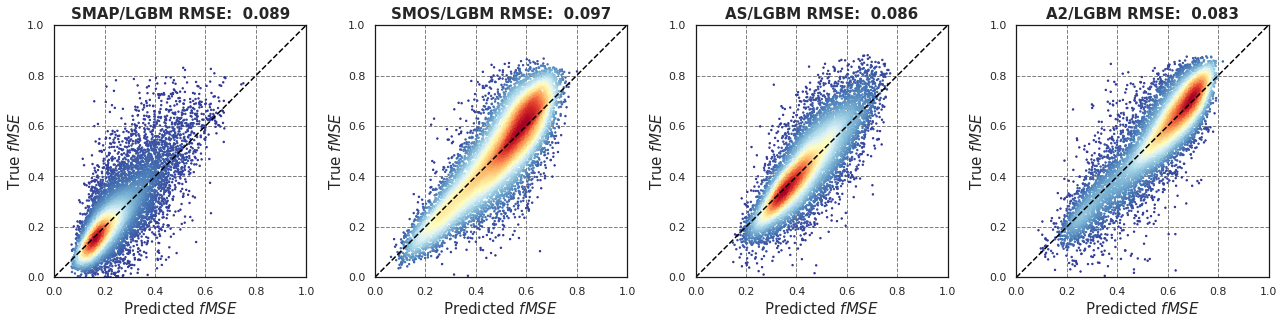

In [4]:
product_list = ['SMAP', 'SMOS', 'AS', 'A2']
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(18,18)
model_list = ['SMAP', 'SMOS', 'ASCAT', 'ASMR2']
for i in range(0,4):
    product = product_list[i]
    print(product)
    ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
    shelf_read(ofp+'_XGB.out')
    #shelf_read(ofp+'_LGBM_RMSE.out')
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    y_pred = grid.predict(X_test)
    #y_pred = all_pred
    xy = np.vstack([y_pred, y_test])
    z = gaussian_kde(xy)(xy)
    
    ax = ax.flatten()
    ax[i].scatter(y_pred, y_test, c=z, s=2, cmap='RdYlBu_r')
    #plt.scatter(1,1)
    ax[i].set_xlabel('Predicted $\it{fMSE}$', size=15)
    ax[i].set_ylabel("True $\it{fMSE}$", size=15)

    ax[i].set_xticks(np.arange(0,1.2,0.2))
    ax[i].set_yticks(np.arange(0,1.2,0.2))
    plt.setp(ax[i].spines.values(), color='k')
    ax[i].grid(b=True, which='major', color='grey', linestyle='--')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,1)
    ax[i].set_facecolor("white")
    ax[i].set_aspect('equal')
    RMSE = mean_squared_error(y_test, y_pred, squared=False
    ax[i].set_title(product+'/LGBM'+f' RMSE: {RMSE: .3f}', size=15, fontweight='bold')
    abline(1,0, ax[i])
fig.tight_layout()
plt.show()
ofp_result = '/home/hyung/Lab/libs/python/DL_Error_results/ML_models/'
fig.savefig(ofp_result+'XGB.png', dpi=300, bbox_inches='tight')

In [6]:
#sc_X = StandardScaler()
#sc_y = StandardScaler()
#X = sc_X.fit_transform(A2_num.values)
#y = sc_y.fit_transform(A2_y.values.reshape(-1, 1))

test_size = 0.33
X = SMOS_num_scaled
y = SMOS_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

array([[-1.7011523 ,  1.22404491,  0.59580679, ..., -0.6933825 ,
        -0.29262382,  0.17239715],
       [-1.7613597 ,  0.99523454, -0.04960371, ..., -0.77762156,
        -0.29262382, -0.56088423],
       [-1.67753502,  0.94742341,  0.46996725, ..., -0.78167829,
        -0.29262382, -0.54202804],
       ...,
       [-0.54117428,  1.30110153,  1.48399609, ..., -0.4562221 ,
         0.80884193,  1.02508944],
       [ 0.67328424, -0.50355101,  0.8789554 , ..., -0.21499138,
        -0.29262382,  1.85392625],
       [-0.49729572, -0.25058671,  1.42244685, ..., -0.32407442,
         0.127598  ,  1.22855095]])

In [5]:
grid_params = {
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [10, 100, 1000, 20000],
    'max_depth': [4, 8, 10],
    'subsample': [0.6, 0.8, 1],
    'seed': [500],
    'colsample_bytree': [0.65, 0.8, 1], 
    'gamma': [0.5, 1, 1.5, 2, 5]
    #'reg_alpha': [0, 1, 2, 6],
    #'reg_lambda': [0, 1, 2, 6]
}

hyper_params={'colsample_bytree':0.8,
              'gamma':0,         
              'learning_rate':0.005,
              'max_depth':8,
              'min_child_weight':1,
              'n_estimators':20000,                                                                    
              'reg_alpha':0.75,
              'reg_lambda':0.45,
              'subsample':0.8,
              'num_iterations':1000,
              'scale_pos_weight':1,
              'seed':42}


#fit_params={'early_stopping_rounds': 1000}
#            'eval_metric': 'mae',
#            'verbose': False,
#            'eval_set': [[X_test, y_test]]}
#n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
#max_depth: The maximum depth of each tree, often values are between 1 and 10.
#eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
#subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
#colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model_XGB = XGBRegressor(**hyper_params)
#model_XGB.fit(X_train, y_train,
#        eval_set=[(X_test, y_test)],
        #eval_metric='l1',
#        early_stopping_rounds=30)
#scores = cross_val_score(model_XGB, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
grid = GridSearchCV(model_XGB, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

In [ ]:
RMSE, RMSE_std = RMSE_KFold(model_XGB, X_train, y_train)
print(RMSE)

In [ ]:
y_pred_XGB = model_XGB.predict(X_test)
rmse = round(mean_squared_error(y_pred_XGB, y_test) ** 0.5, 5)
print('The rmse of prediction is:', rmse)

In [ ]:
y_pred = model_XGB.predict(X_test)
fig, ax = plt.subplots()
xy = np.vstack([y_pred, y_test])
z = gaussian_kde(xy)(xy)
#i=0
#ax = ax.flatten()
ax.scatter(y_pred, y_test, c=z, s=2, cmap='RdYlBu_r')
#plt.scatter(1,1)
ax.set_xlabel('Predicted $\it{fMSE}$', size=15)
ax.set_ylabel("True $\it{fMSE}$", size=15)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
plt.setp(ax.spines.values(), color='k')
ax.grid(b=True, which='major', color='grey', linestyle='--')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_facecolor("white")
ax.set_aspect('equal')
abline(1,0, ax)
ax.set_title('XGB RMSE: '+np.str(rmse), size=15, fontweight='bold')

In [ ]:
#mse = mean_squared_error(sc_y.inverse_transform(y_test), sc_y.inverse_transform(y_pred))
#mse = mean_squared_error(y_test, y_pred)
#rmse = np.sqrt(mse)